Test if the simulator (Hamiltonian + various noise models) and the datasets that are generated through the simulator have a good match against experimental data and device models (analytically created) i.e., 
- Do the probability distributions from the end outcomes of the simulator match what we collected through experiment?
- Do the probability distributions from the end outcomes of the simulator match the analytic expressions from model description (both what we have coded up in quantum_device_models and estimators)?

#### Add paths and libraries

In [1]:
# Imports
import os, sys, types
import pathlib

In [2]:
# Add paths
import itertools
import math
import sympy
import numpy as np
import scipy.linalg
import scipy.stats
import scipy.optimize
import scipy.fftpack

import tensorflow  as  tf
tf.compat.v1.enable_eager_execution(config=None, device_policy=None, execution_mode=None)

#import seaborn as sns
#import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

import pickle

from importlib import reload
from sympy.physics.quantum.dagger import Dagger

In [3]:
# Local package imports
# Update this with setup & develop later
PROJECT_PATH = str(pathlib.Path().resolve().parent)
sys.path.append(PROJECT_PATH)

In [4]:
import hamiltonianlearner

Instructions for updating:
non-resource variables are not supported in the long term


In [5]:
import hamiltonianlearner.quantum_system_oracles.process_data as process_data
import hamiltonianlearner.quantum_system_oracles.simulate_nature as simulate_nature
import hamiltonianlearner.quantum_system_models.quantum_device_models as quantum_device_models
import hamiltonianlearner.learners.design_experiment as design_experiment

In [6]:
# estimators
import hamiltonianlearner.estimators.initial_estimators as initial_estimators
import hamiltonianlearner.estimators.mle_estimators as mle_estimators
import hamiltonianlearner.estimators.estimation_procedure as estimation_procedure

In [7]:
# For plotting purposes
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [8]:
import yaml
#import unit_tests
import functools

In [9]:
import hamiltonianlearner.utils.learner_experiment_utils as learner_experiment_utils
import hamiltonianlearner.utils.job_helper as job_helper

In [10]:
# Cool reloading
# Reference: https://stackoverflow.com/questions/28101895/reloading-packages-and-their-submodules-recursively-in-python

def reload_package(package):
    assert(hasattr(package, "__package__"))
    fn = package.__file__
    fn_dir = os.path.dirname(fn) + os.sep
    module_visit = {fn}
    del fn

    def reload_recursive_ex(module):
        reload(module)

        for module_child in vars(module).values():
            if isinstance(module_child, types.ModuleType):
                fn_child = getattr(module_child, "__file__", None)
                if (fn_child is not None) and fn_child.startswith(fn_dir):
                    if fn_child not in module_visit:
                        # print("reloading:", fn_child, "from", module)
                        module_visit.add(fn_child)
                        reload_recursive_ex(module_child)

    return reload_recursive_ex(package)

#### Global parameters and constants

In [11]:
def kron(a, b):
    return np.matrix(scipy.linalg.kron(a, b))

In [12]:
si = np.array([ [1, 0], [0, 1] ])
sx = np.array([ [0, 1], [1, 0] ])
sy = np.array([ [0, -1j], [1j, 0] ])
sz = np.array([ [1, 0], [0, -1] ])

# According to Ed's slides and answers verified -- match!
moset = {0: [si,scipy.linalg.expm(1j*(np.pi/4)*sy)], 1: [si,scipy.linalg.expm(-1j*(np.pi/4)*sx)], 2: [si,si]}
prepset = {0: [si, si], 1: [sx, si]}

In [13]:
# Time Stamps similar to data
time_stamps = np.linspace(1e-7,6e-7,81)

In [14]:
scipy.linalg.expm(1j*(np.pi/4)*sy)

array([[ 0.70710678+0.j,  0.70710678+0.j],
       [-0.70710678+0.j,  0.70710678+0.j]])

In [15]:
scipy.linalg.expm(-1j*(np.pi/4)*sx)

array([[0.70710678+0.j        , 0.        -0.70710678j],
       [0.        -0.70710678j, 0.70710678+0.j        ]])

#### Quickly load an IBM dataset

In [13]:
# ibmq_boeblingen data

# Parameters of the different jobs
meas_level_expt = 1
n_shots = 512
n_job = 1
cr_amp_array = [0.24, 0.30, 0.36, 0.42, 0.48]

In [14]:
ind_amp = 1
pickle_result_filename = 'ibmq_boel_fixed_qs_data_aligned_A_0_%d_meas_%d_shots_%d_job_%d.pickle' % (100*cr_amp_array[ind_amp], meas_level_expt,
                                                                           n_shots, n_job)
pickle_result_file = 'Data/ibmq_boel/'+pickle_result_filename

In [15]:
# Readout calibration and formatting again
ibm_data = process_data.make_dataset_ibmq_device(pickle_result_file, FLAG_classification=True, do_plot=False)

In [16]:
ibm_data['misclassif_error']

[0.0078125, 0.033203125]

# 1. Noiseless simulator

In [63]:
# Setup oracle -- simulator
print('Using J_num which we already discovered before!')
J_num = np.array([-4591284.15156123, -1378867.53815859,  -416336.60548091,
                    6513769.17811964,  1377973.27790347,   528855.26396758])

param_truth = quantum_device_models.transform_parameters(J_truth)

## Oracle properties
FLAG_simulator = True

## Noise Models
FLAG_readout_noise = False
FLAG_control_noise = False

# Control Noise
teff = quantum_device_models.data_driven_teff_noise_model(param_truth, FLAG_ibmq_boel=True)
expt_noise = {'readout':ibm_data['misclassif_error'], 
              'imperfect_pulse_shaping':teff}

# Create oracle
env_qs = simulate_nature.Nature(J_truth, noise=expt_noise, expt_data=None,
                                FLAG_simulator=FLAG_simulator,
                                FLAG_readout_noise=FLAG_readout_noise,
                                FLAG_control_noise=FLAG_control_noise)

Using J_num which we already discovered before!
Simulator oracle setup


In [64]:
env_qs.print_info()

Oracle: Simulator
Noise Sources:
Readout Noise: FLAG=False, Value=[0. 0.]
Control Noise: FLAG=False
Decoherence: FLAG=False


In [65]:
# Some normalization factors
xi_J = 10**np.amax(np.floor(np.log10(np.abs(J_truth))))*np.ones(len(J_truth))
xi_t = 1e-7

In [66]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,6,81)
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J, 
                                    freq_convert=ibm_data['freq_convert'])

In [67]:
# Rabi oscillations from the noiseless scenario -- a lot of data
N_config = A_cr.N_actions
p_U = (1 / N_config) * np.ones(N_config)

N_queries = 40*N_config
X_p = A_cr.sample_action_space(env_qs, p_U, N_queries, FLAG_query=True)

In [68]:
A_cr.update_dict_action_space(X_p)

In [69]:
pvec = A_cr.rabi_data()

In [70]:
qs_noise = {'readout': env_qs.readout_noise,
            'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                               FLAG_ibmq_boel=True),
            'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                    FLAG_ibmq_boel=True)}

qs_model = quantum_device_models.SystemModel(J_truth, 1e6 * np.ones(len(J_truth)), noise=qs_noise,
                                             FLAG_readout_noise=FLAG_readout_noise, 
                                             FLAG_control_noise=FLAG_control_noise)

In [71]:
qs_model.print_info()

Quantum Device Model Info:
Noise Sources:
Readout Noise: FLAG=False, Value=[0. 0.]
Control Noise: FLAG=False
Decoherence: FLAG=False
Leakage Error: FLAG=False


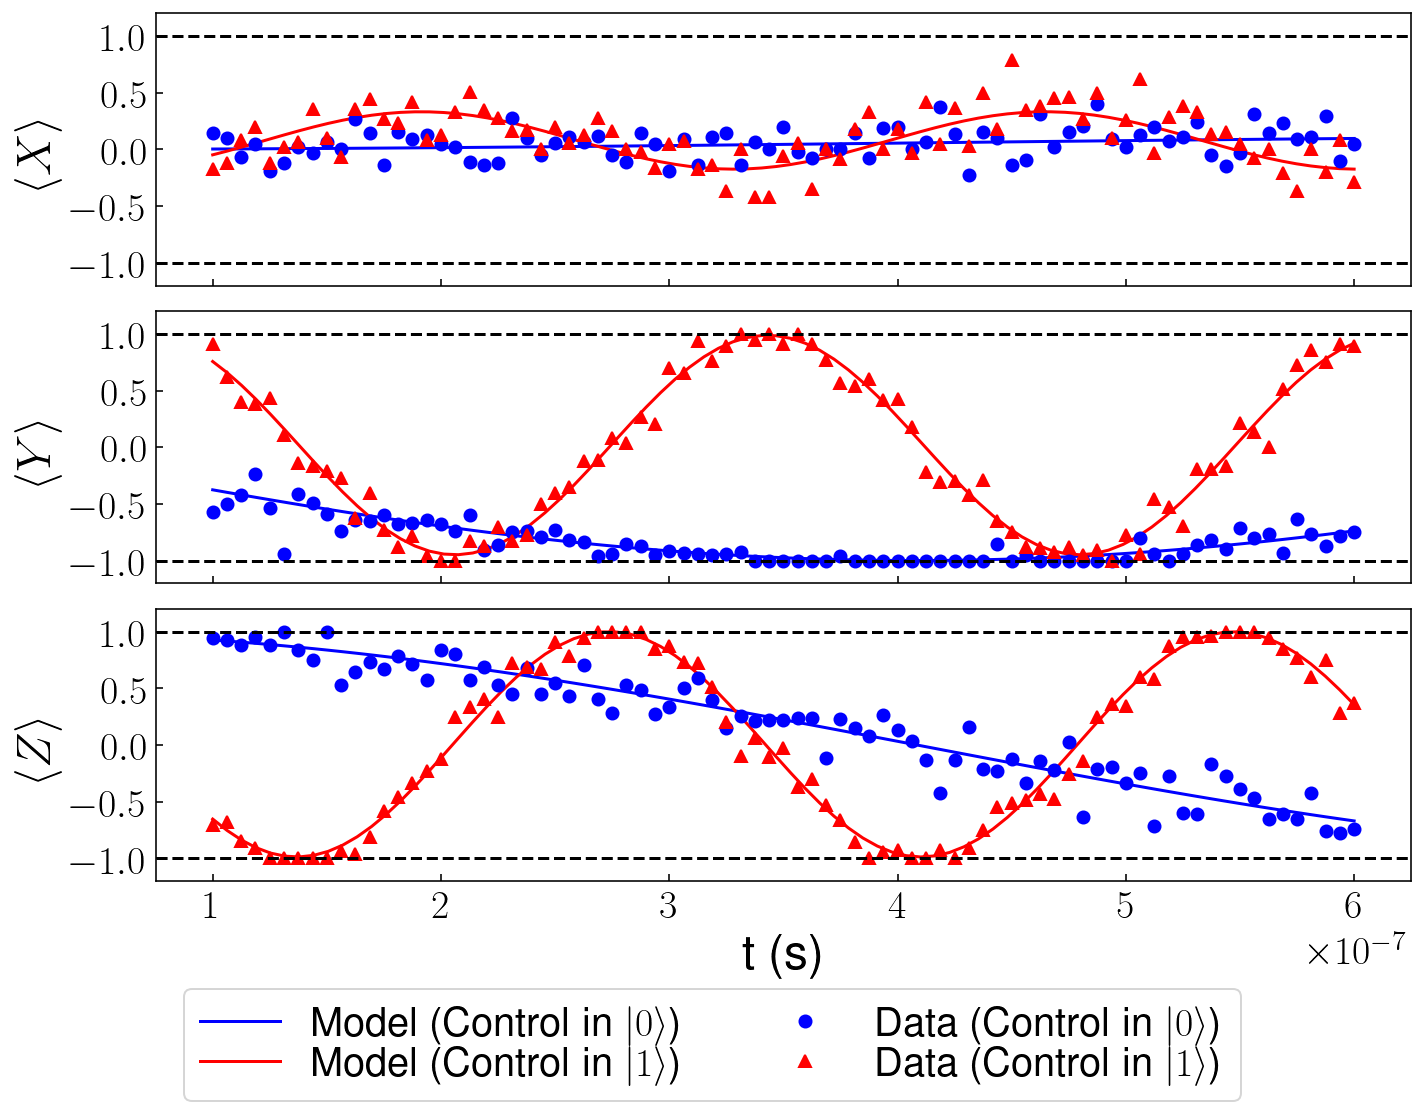

In [72]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=pvec, 
                                                    qs_model=qs_model, FLAG_noise=False)

# 2. Noisy simulator

## 2.1 Simulator with Decoherence

In [73]:
reload_package(hamiltonianlearner)

In [74]:
# Load the relevant IBM dataset to reuse the time-information from there
n_jobs=4

# Setup the required arrays
pvec_data = np.empty((6,0))
tvec_data = []

for n_job in range(n_jobs):
    print(n_job)
    # Load pickle file for job
    pickle_result_filename = "ibmq_boel_adaptive_qs_data_aligned_A_0_30_meas_1_shots_512_job_%d.pickle" % n_job

    pickle_result_file = 'Data/ibmq_boel/'+pickle_result_filename
    ibm_data = process_data.make_dataset_ibmq_device(pickle_result_file, FLAG_classification=True, FLAG_save=False, do_plot=False)

    time_temp, pvec_temp = simulate_nature.compare_prediction_data(ibm_data, FLAG_readout_noise=True, do_plot=False, FLAG_return=True)
    
    tvec_data = np.append(tvec_data, time_temp)
    pvec_data = np.append(pvec_data, pvec_temp, axis=1)

0
1
2
3


In [107]:
ibm_data

{'mvec': array([0, 0, 0, ..., 2, 2, 2]),
 'uvec': array([0, 0, 0, ..., 1, 1, 1]),
 'tvec': array([3.65155556e-06, 3.65155556e-06, 3.65155556e-06, ...,
        7.60177778e-06, 7.60177778e-06, 7.60177778e-06]),
 'time_stamps': array([3.65155556e-06, 3.70133333e-06, 3.75111111e-06, 3.80088889e-06,
        3.85066667e-06, 3.90044444e-06, 3.95022222e-06, 4.00000000e-06,
        4.05333333e-06, 4.10311111e-06, 4.15288889e-06, 4.20266667e-06,
        4.25244444e-06, 4.30222222e-06, 4.35200000e-06, 4.40177778e-06,
        4.45155556e-06, 4.50133333e-06, 4.55111111e-06, 4.60088889e-06,
        4.65066667e-06, 4.70044444e-06, 4.75022222e-06, 4.80000000e-06,
        4.85333333e-06, 4.90311111e-06, 4.95288889e-06, 5.00266667e-06,
        5.05244444e-06, 5.10222222e-06, 5.15200000e-06, 5.20177778e-06,
        5.25155556e-06, 5.30133333e-06, 5.35111111e-06, 5.40088889e-06,
        5.45066667e-06, 5.50044444e-06, 5.55022222e-06, 5.60355556e-06,
        5.65333333e-06, 5.70311111e-06, 5.75288889e-06, 

In [75]:
# Setup oracle -- simulator
print('Using J_num which we already discovered before!')

# Potential truth
J_truth = np.array([-4591284.15156123, -1378867.53815859,  -416336.60548091,
                    6513769.17811964,  1377973.27790347,   528855.26396758])

param_truth = quantum_device_models.transform_parameters(J_truth)

## Oracle properties
FLAG_simulator = True

## Noise Models
FLAG_readout_noise = False
FLAG_control_noise = True
FLAG_decoherence = True

# Decoherence Noise Model
qs_T1 = 1e-6*np.array([94.0278, 75.71162])
qs_T2 = 1e-6*np.array([177.22575, 128.0758598])

decoherence_model = functools.partial(quantum_device_models.decoherence_single_qubit_model, t1=np.mean(qs_T1), t2=np.mean(qs_T2))
decoherence_model2 = functools.partial(quantum_device_models.decoherence_two_qubit_model, 
                                       t1_array=qs_T1, 
                                       t2_array=qs_T2)

# Control Noise
teff = quantum_device_models.data_driven_teff_noise_model(param_truth, FLAG_ibmq_boel=True)
expt_noise ={'readout':ibm_data['misclassif_error'], 
             'imperfect_pulse_shaping':teff,
             'decoherence_model': decoherence_model2}

# Create oracle
env_qs = simulate_nature.Nature(J_truth, noise=expt_noise, expt_data=None,
                                FLAG_simulator=FLAG_simulator,
                                FLAG_readout_noise=FLAG_readout_noise,
                                FLAG_control_noise=FLAG_control_noise,
                                FLAG_decoherence=FLAG_decoherence)

Using J_num which we already discovered before!
Simulator oracle setup


In [76]:
env_qs.print_info()

Oracle: Simulator
Noise Sources:
Readout Noise: FLAG=False, Value=[0. 0.]
Control Noise: FLAG=True
Decoherence: FLAG=True


In [77]:
# Define corresponding QuantumDeviceModel
qs_noise = {'readout': env_qs.readout_noise,
            'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                               FLAG_ibmq_boel=True),
            'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                    FLAG_ibmq_boel=True),
            'T1': qs_T1,
            'T2': qs_T2,
            'decoherence': decoherence_model2}

qs_model = quantum_device_models.SystemModel(J_truth, 1e6 * np.ones(len(J_truth)), noise=qs_noise,
                                             FLAG_readout_noise=FLAG_readout_noise, 
                                             FLAG_control_noise=FLAG_control_noise,
                                             FLAG_decoherence=FLAG_decoherence)

In [78]:
qs_model.print_info()

Quantum Device Model Info:
Noise Sources:
Readout Noise: FLAG=False, Value=[0. 0.]
Control Noise: FLAG=True
Decoherence: FLAG=True
Leakage Error: FLAG=False


### Short time range

In [79]:
# Some normalization factors
xi_J = 10**np.amax(np.floor(np.log10(np.abs(J_truth))))*np.ones(len(J_truth))
xi_t = 1e-7

In [80]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,6,81)
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J, 
                                    freq_convert=ibm_data['freq_convert'])

In [81]:
# Rabi oscillations
N_config = A_cr.N_actions
p_U = (1 / N_config) * np.ones(N_config)

N_queries = 40*N_config
X_p = A_cr.sample_action_space(env_qs, p_U, N_queries, FLAG_query=True)

In [82]:
A_cr.update_dict_action_space(X_p)

In [83]:
pvec = A_cr.rabi_data()

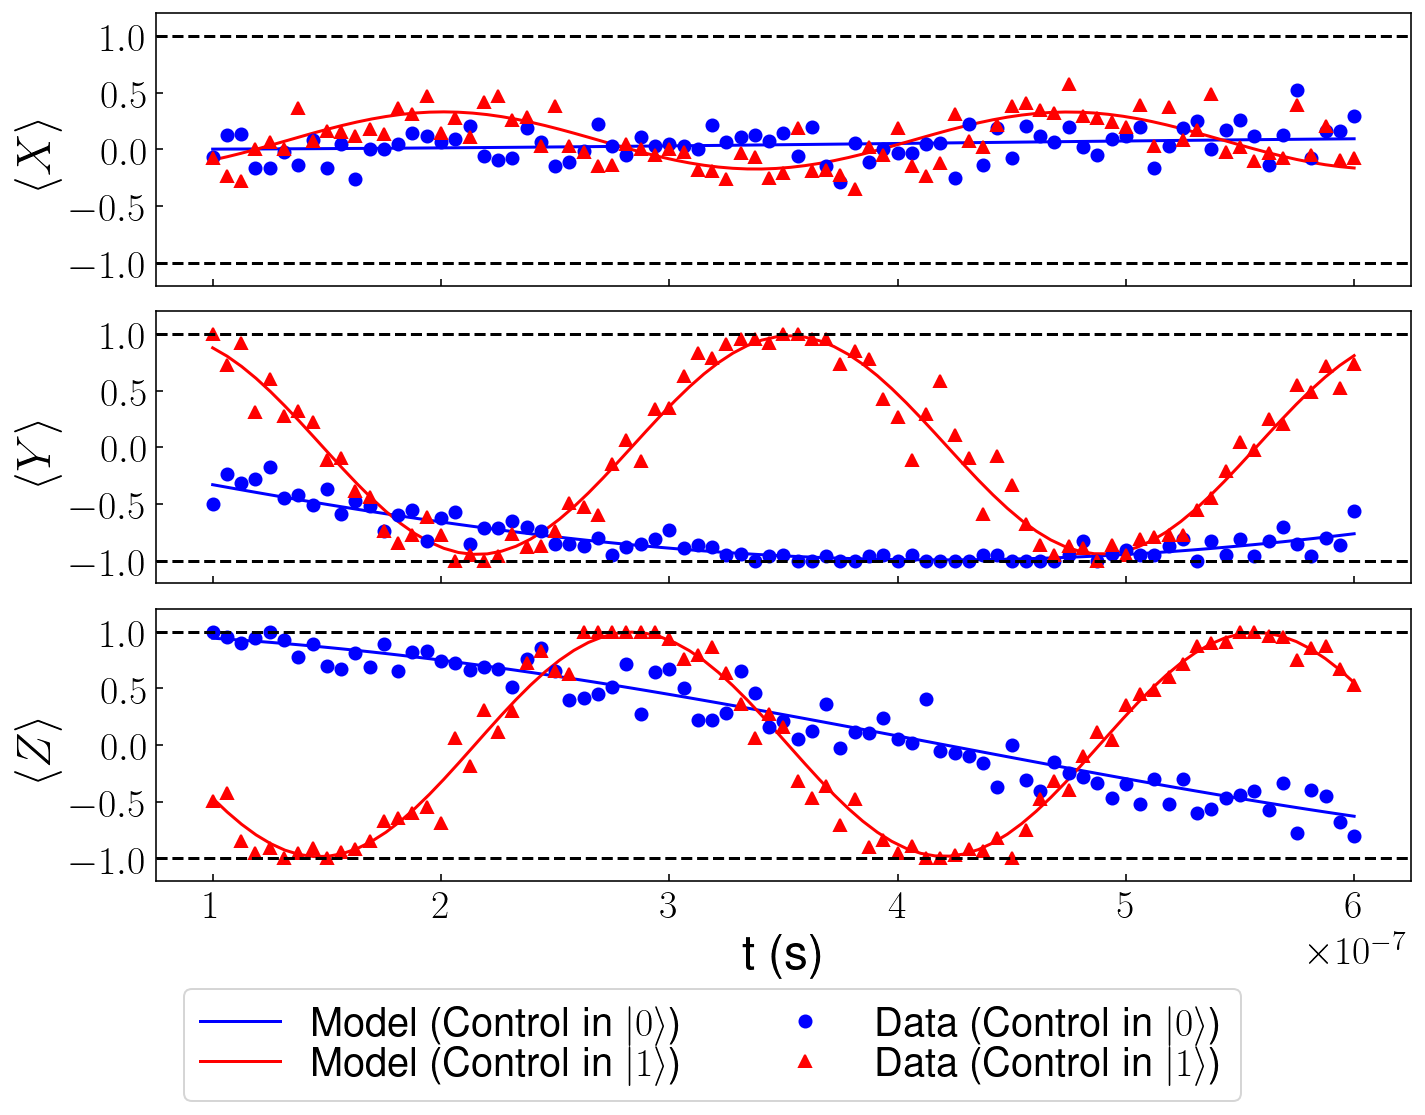

In [84]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=pvec, 
                                                    qs_model=qs_model, FLAG_noise=True)

### Long time range -- from data

In [101]:
# Some normalization factors
xi_J = 10**np.amax(np.floor(np.log10(np.abs(J_truth))))*np.ones(len(J_truth))
xi_t = 1e-7

In [102]:
# Setup the action space as in the fixed query space
time_stamps_nd = tvec_data/xi_t
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J, 
                                    freq_convert=ibm_data['freq_convert'])

In [103]:
# Rabi oscillations
N_config = A_cr.N_actions
p_U = (1 / N_config) * np.ones(N_config)

N_queries = 40*N_config
X_p = A_cr.sample_action_space(env_qs, p_U, N_queries, FLAG_query=True)

In [104]:
A_cr.update_dict_action_space(X_p)

In [105]:
pvec = A_cr.rabi_data()

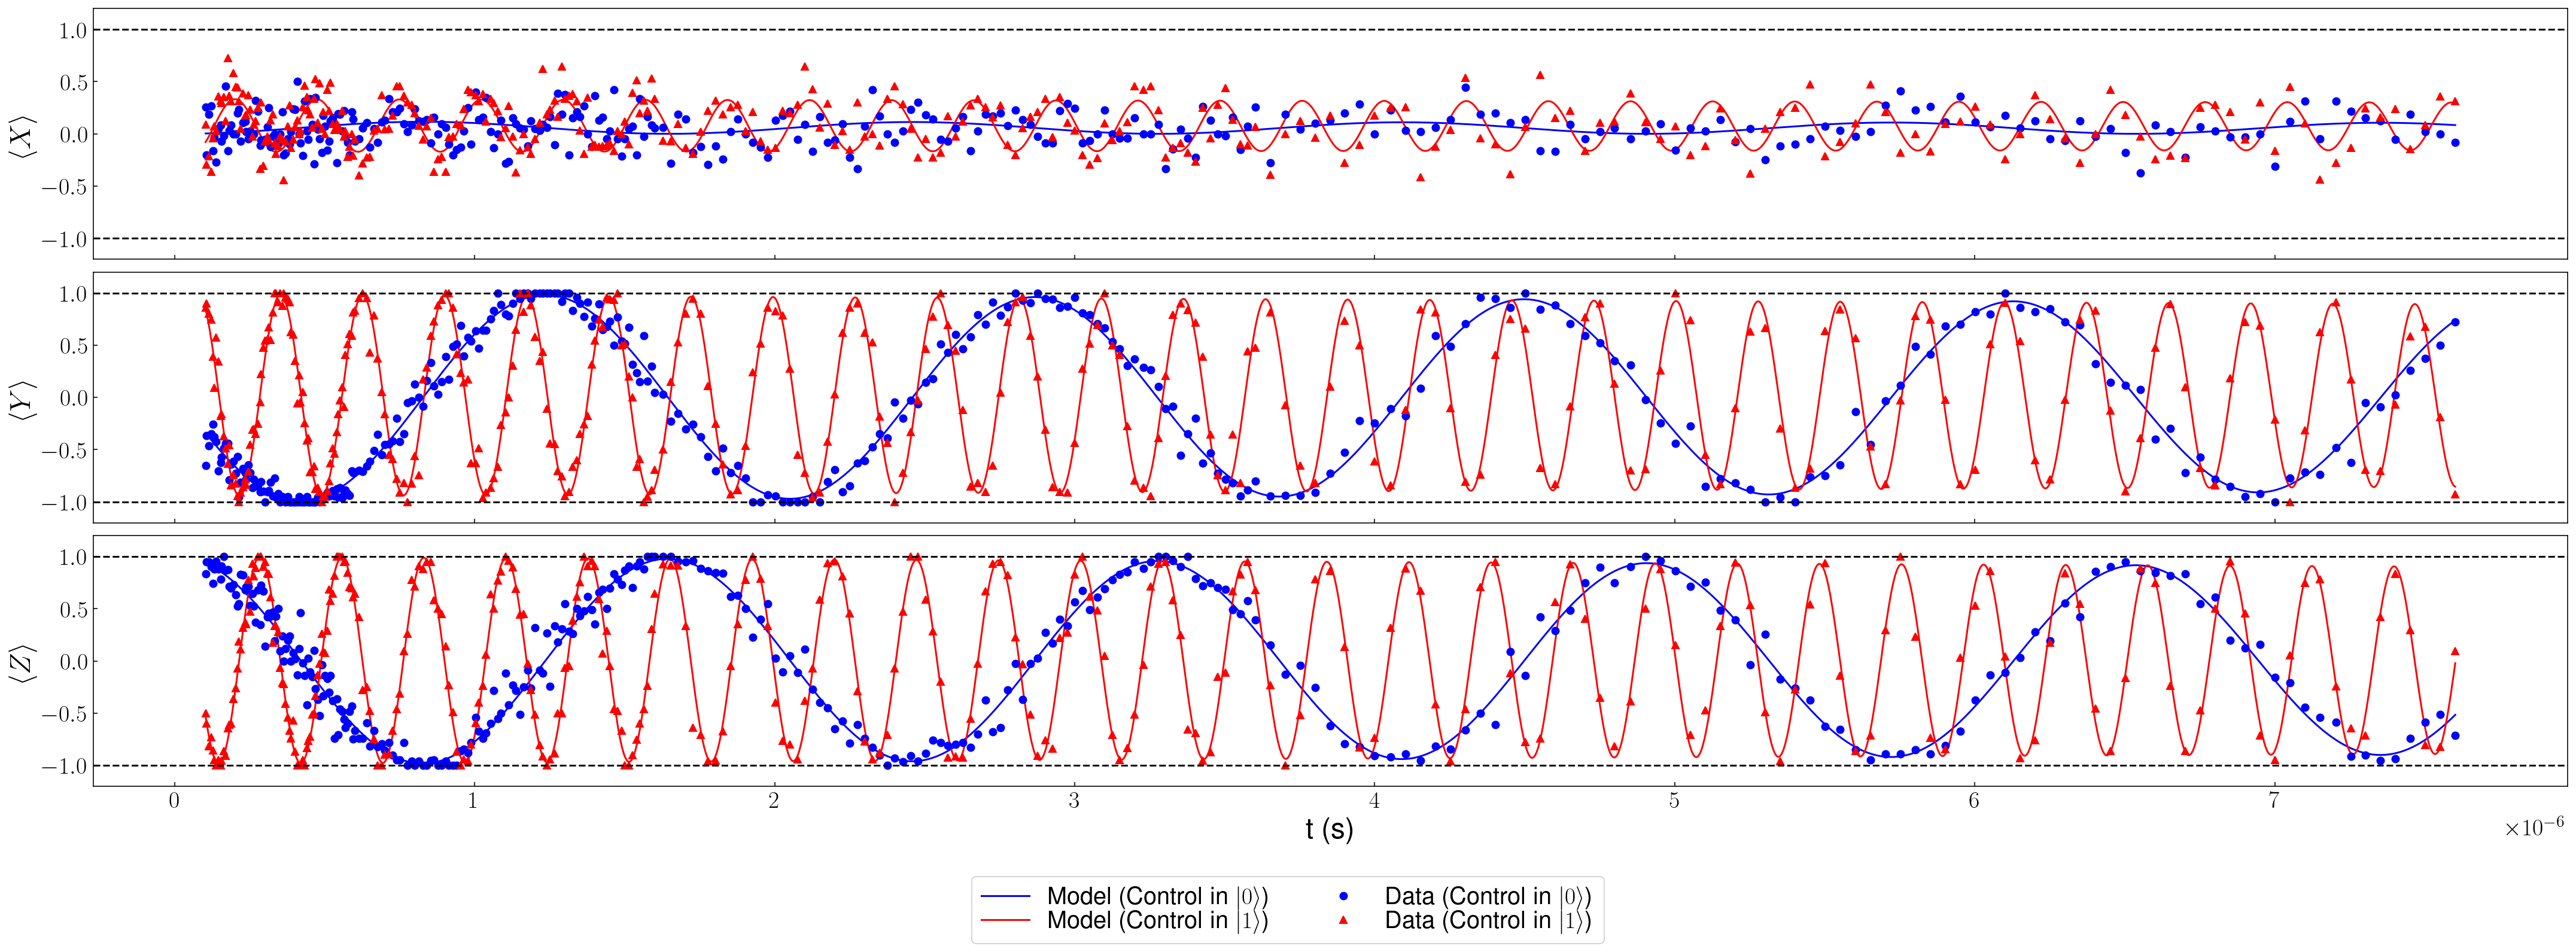

In [106]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, 
                                                    pvec_data=pvec, figsize_plot=(30,10),
                                                    qs_model=qs_model, FLAG_noise=True)

## 2.2 Simulator with Readout Noise and Leakage Errors

### 2.2.1 Erasure Error

In [195]:
## Noise Models
FLAG_readout_noise = False
FLAG_control_noise = False
FLAG_leakage = True

qs_T1 = 1e-6*np.array([94.0278, 75.71162])
qs_T2 = 1e-6*np.array([177.22575, 128.0758598])

qs_noise = {'readout': env_qs.readout_noise,
                    'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                               FLAG_ibmq_boel=True),
                    'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                    FLAG_ibmq_boel=True)}

qs_model = quantum_device_models.SystemModel(J_truth, 1e6 * np.ones(len(J_truth)), noise=qs_noise,
                                             FLAG_readout_noise=FLAG_readout_noise, 
                                             FLAG_control_noise=FLAG_control_noise)

qs_noise_leakage = {'readout': env_qs.readout_noise,
                    'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                               FLAG_ibmq_boel=True),
                    'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                    FLAG_ibmq_boel=True),
                    'leakage_model': 'erasure',
                    'mu_T': qs_T1[1],
                    'leakage_rate': np.array([0.05,0])}

qs_model_leakage_erasure = quantum_device_models.SystemModel(J_truth, 1e6 * np.ones(len(J_truth)), noise=qs_noise_leakage,
                                                     FLAG_readout_noise=FLAG_readout_noise, 
                                                     FLAG_control_noise=FLAG_control_noise,
                                                     FLAG_leakage=FLAG_leakage)

"Nature" without leakage errors

In [146]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,6,81)
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J, 
                                    freq_convert=ibm_data['freq_convert'])

In [147]:
# Rabi oscillations from the "Hamiltonian"
N_config = A_cr.N_actions
p_U = (1 / N_config) * np.ones(N_config)

N_queries = 40*N_config
X_p = A_cr.sample_action_space_quantum_dev_model(qs_model, p_U, N_queries, FLAG_query=True)

In [148]:
A_cr.update_dict_action_space(X_p)
pvec_data = A_cr.rabi_data()

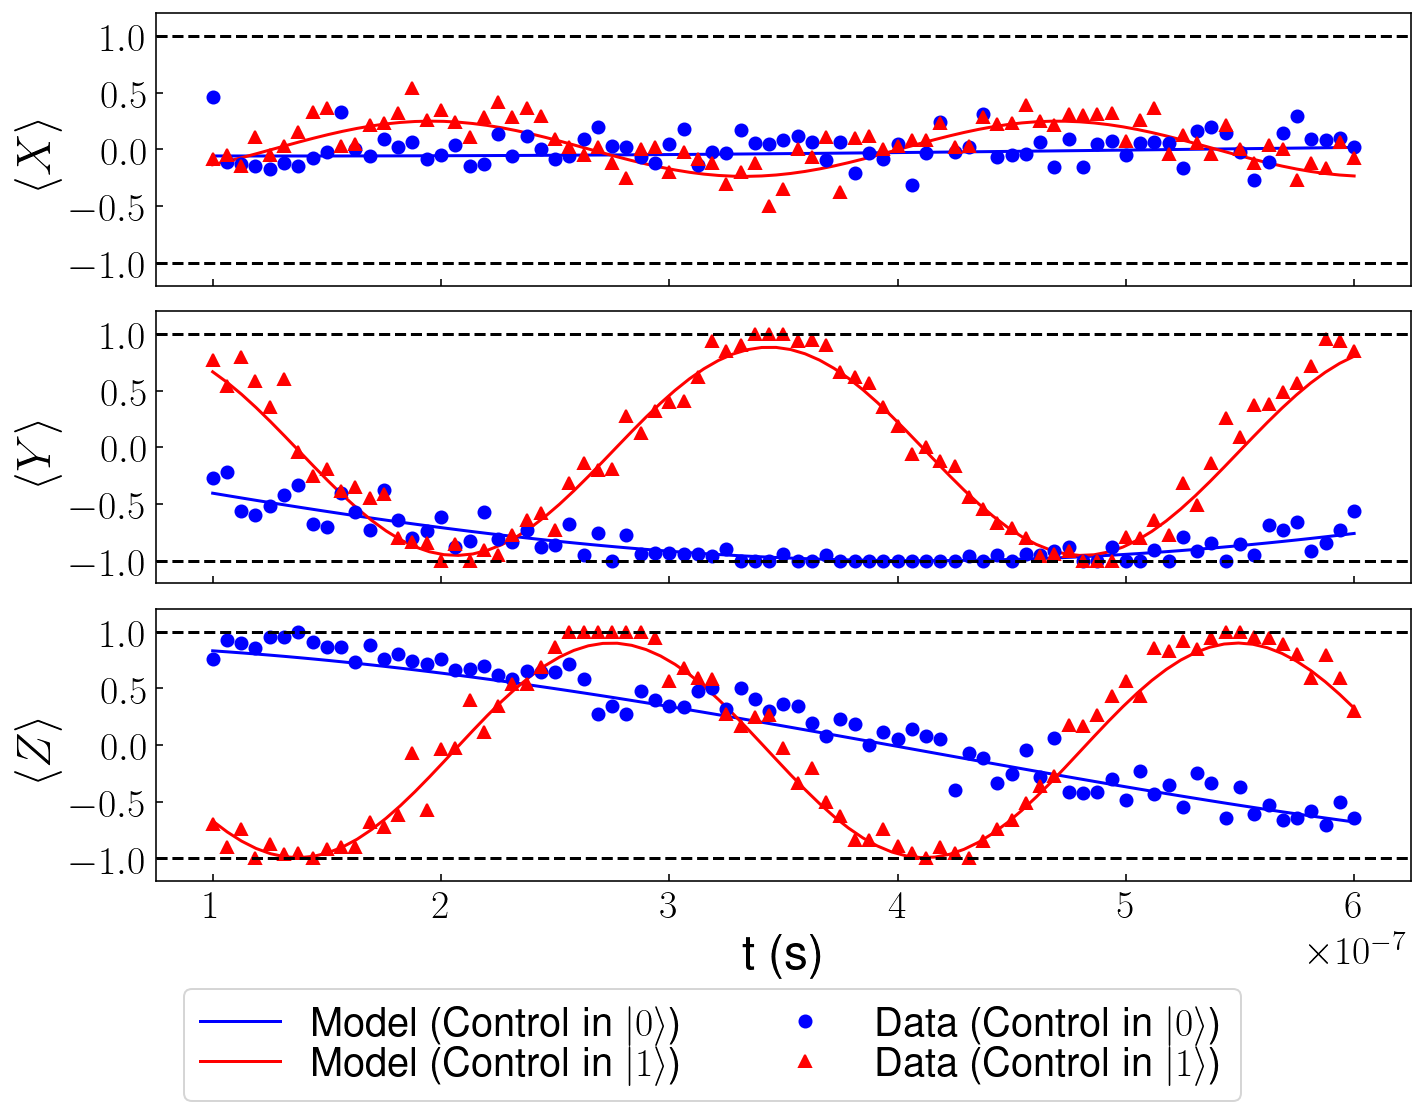

In [149]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=pvec_data, 
                                                    qs_model=qs_model_leakage, FLAG_noise=True)

Modification of "nature" to include leakage errors

In [151]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,6,81)
A_cr = simulate_nature.Action_Space(moset, prepset, time_stamps_nd, xi_t, xi_J=xi_J, 
                                    freq_convert=ibm_data['freq_convert'])

In [152]:
# Rabi oscillations from the "Hamiltonian + Erasure Leakage Error"
N_config = A_cr.N_actions
p_U = (1 / N_config) * np.ones(N_config)

N_queries = 40*N_config
X_p = A_cr.sample_action_space_quantum_dev_model(qs_model_leakage, p_U, N_queries, FLAG_query=True)

In [153]:
A_cr.update_dict_action_space(X_p)
pvec_data_leakage = A_cr.rabi_data()

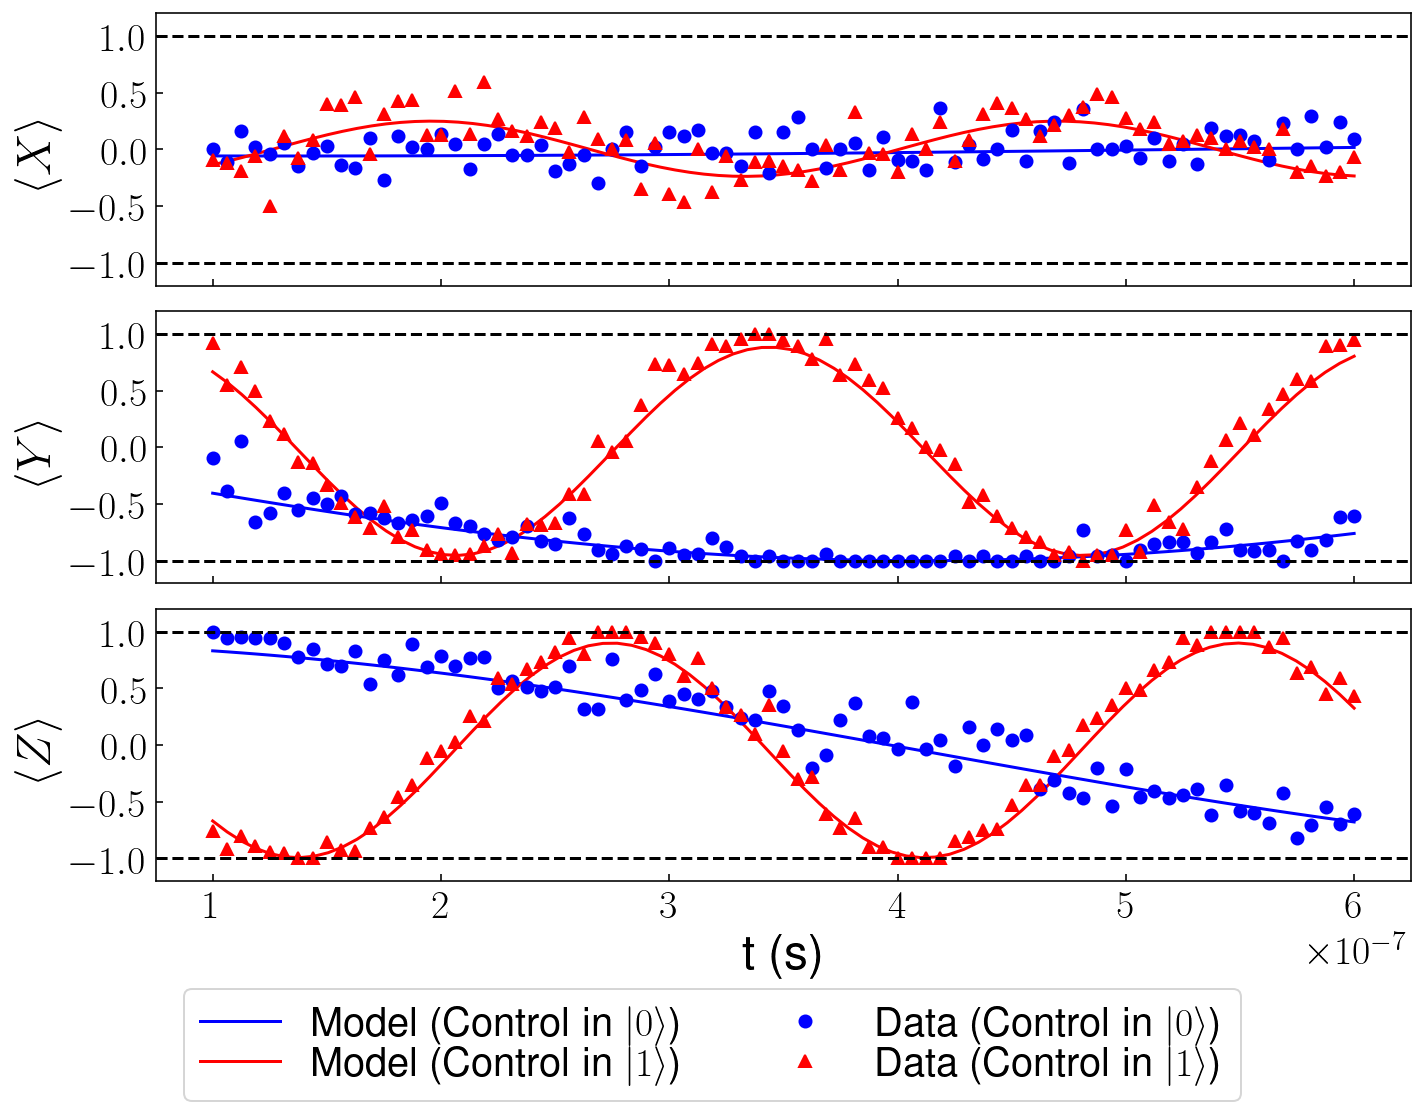

In [154]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=pvec_data_leakage, 
                                                    qs_model=qs_model_leakage, FLAG_noise=True)

Modification of rabi oscillations in quantum_device_models with presence of leakage error

In [155]:
reload(simulate_nature)
reload(quantum_device_models)

<module 'hamiltonianlearner.quantum_device_models' from '/Users/gogol/Dropbox (Personal)/Research/Pulse_Shaping/IBM_Code/Hamiltonian_Learning/active_hamiltonian_learning/cases/IBM_Device/hamiltonianlearner/quantum_device_models.py'>

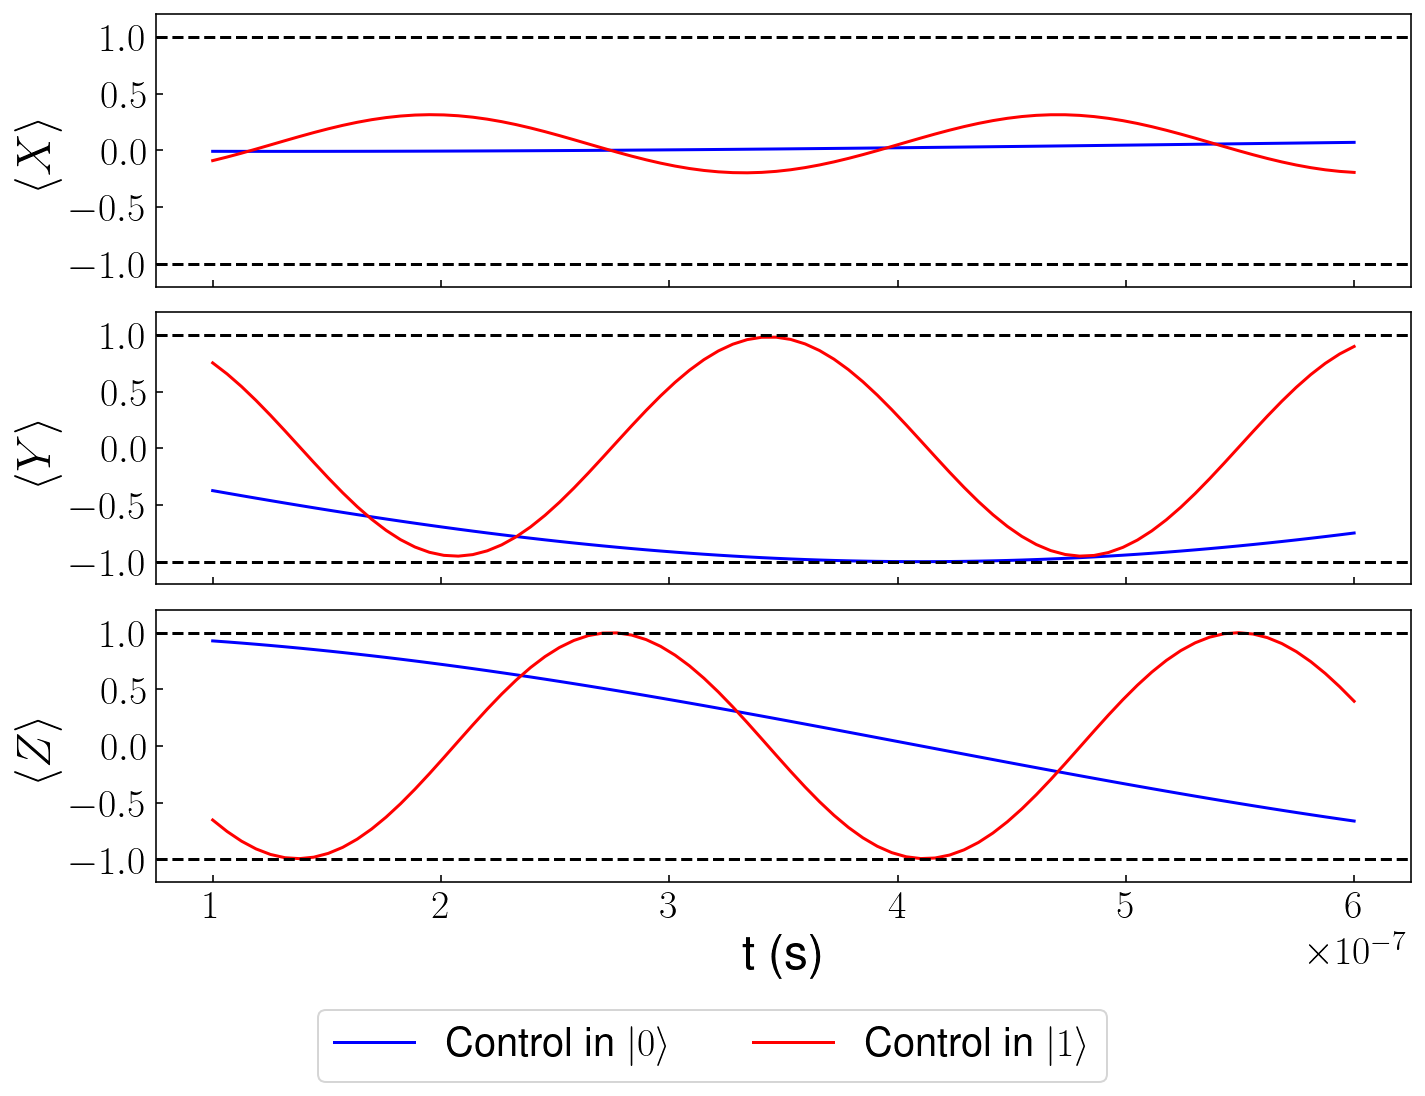

In [156]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=None, 
                                                    qs_model=qs_model, FLAG_noise=True)

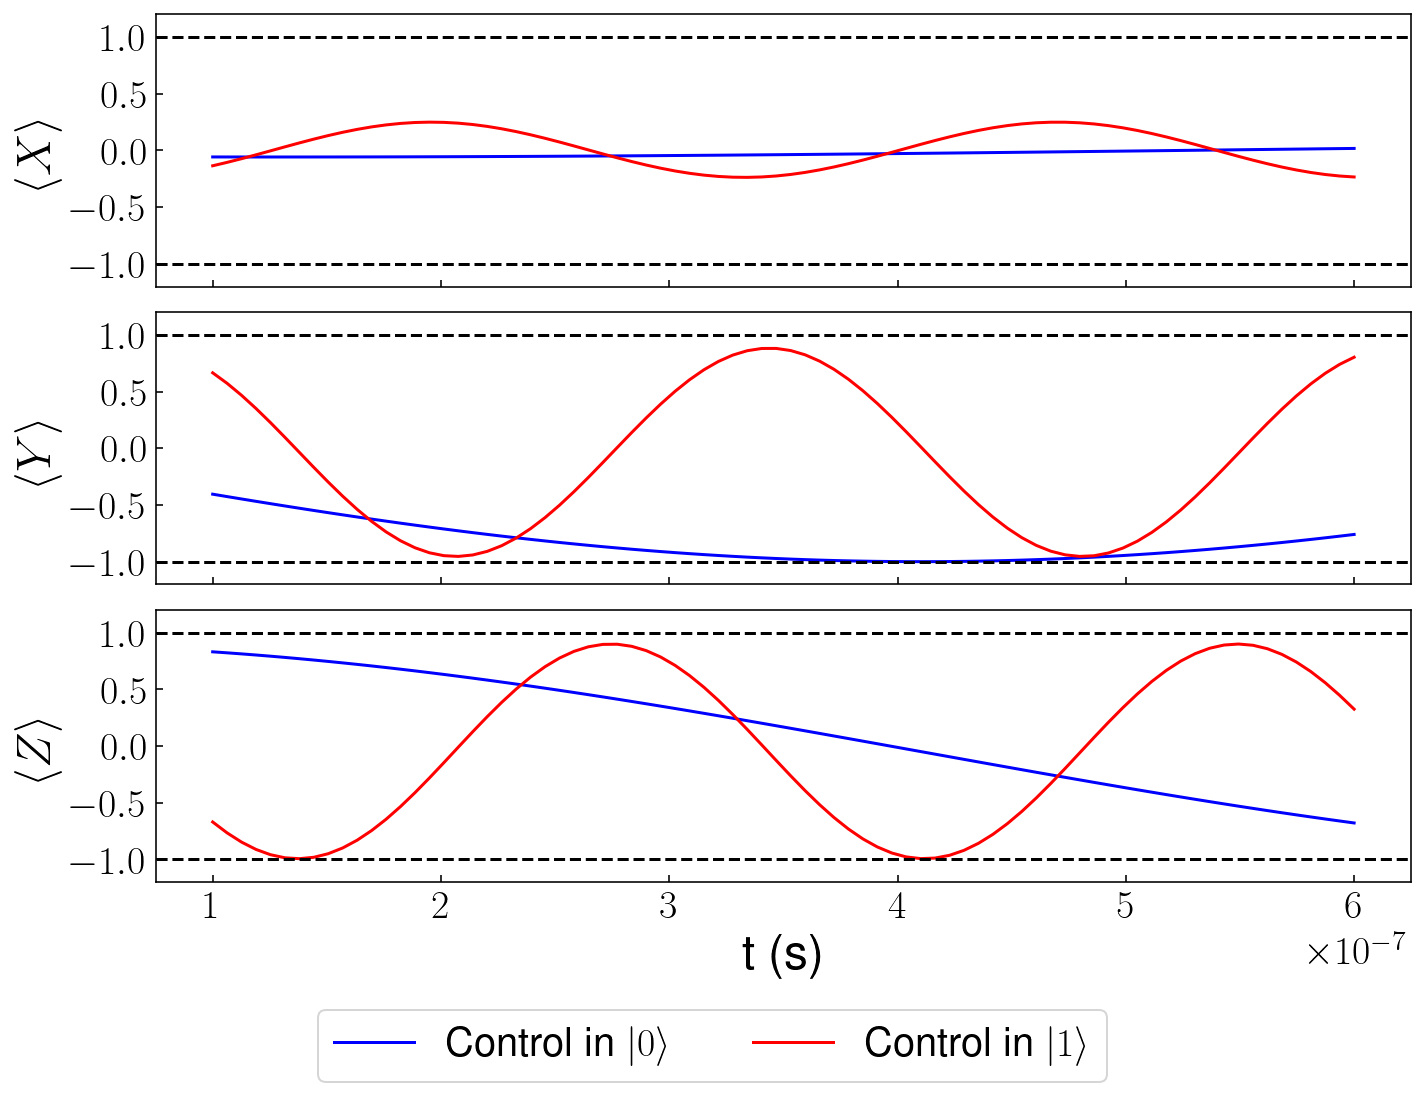

In [157]:
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=None, 
                                                    qs_model=qs_model_leakage, FLAG_noise=True)

### 2.3.1 Depolarization Leakage Extension

In [171]:
reload(quantum_device_models)

<module 'hamiltonianlearner.quantum_device_models' from '/Users/gogol/Dropbox (Personal)/Research/Pulse_Shaping/IBM_Code/Hamiltonian_Learning/active_hamiltonian_learning/cases/IBM_Device/hamiltonianlearner/quantum_device_models.py'>

In [205]:
## Noise Models
FLAG_readout_noise = False
FLAG_control_noise = False
FLAG_leakage = True

qs_T1 = 1e-6*np.array([94.0278, 75.71162])
qs_T2 = 1e-6*np.array([177.22575, 128.0758598])

qs_noise = {'readout': env_qs.readout_noise,
                    'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                               FLAG_ibmq_boel=True),
                    'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                    FLAG_ibmq_boel=True)}

qs_model = quantum_device_models.SystemModel(J_truth, 1e6 * np.ones(len(J_truth)), noise=qs_noise,
                                             FLAG_readout_noise=FLAG_readout_noise, 
                                             FLAG_control_noise=FLAG_control_noise)

qs_noise_leakage = {'readout': env_qs.readout_noise,
                    'control_noise': functools.partial(quantum_device_models.data_driven_teff_noise_model,
                                               FLAG_ibmq_boel=True),
                    'grad_control_noise': functools.partial(quantum_device_models.grad_data_driven_teff_noise_model,
                                                    FLAG_ibmq_boel=True),
                    'leakage_model': 'dle_quadratic',
                    'mu_T': qs_T1[1],
                    'leakage_rate': np.array([0.05,0])}

qs_model_leakage_quadratic = quantum_device_models.SystemModel(J_truth, 1e6 * np.ones(len(J_truth)), noise=qs_noise_leakage,
                                                     FLAG_readout_noise=FLAG_readout_noise, 
                                                     FLAG_control_noise=FLAG_control_noise,
                                                     FLAG_leakage=FLAG_leakage)

In [185]:
# Setup the action space as in the fixed query space
time_stamps_nd = np.linspace(1,60,810)

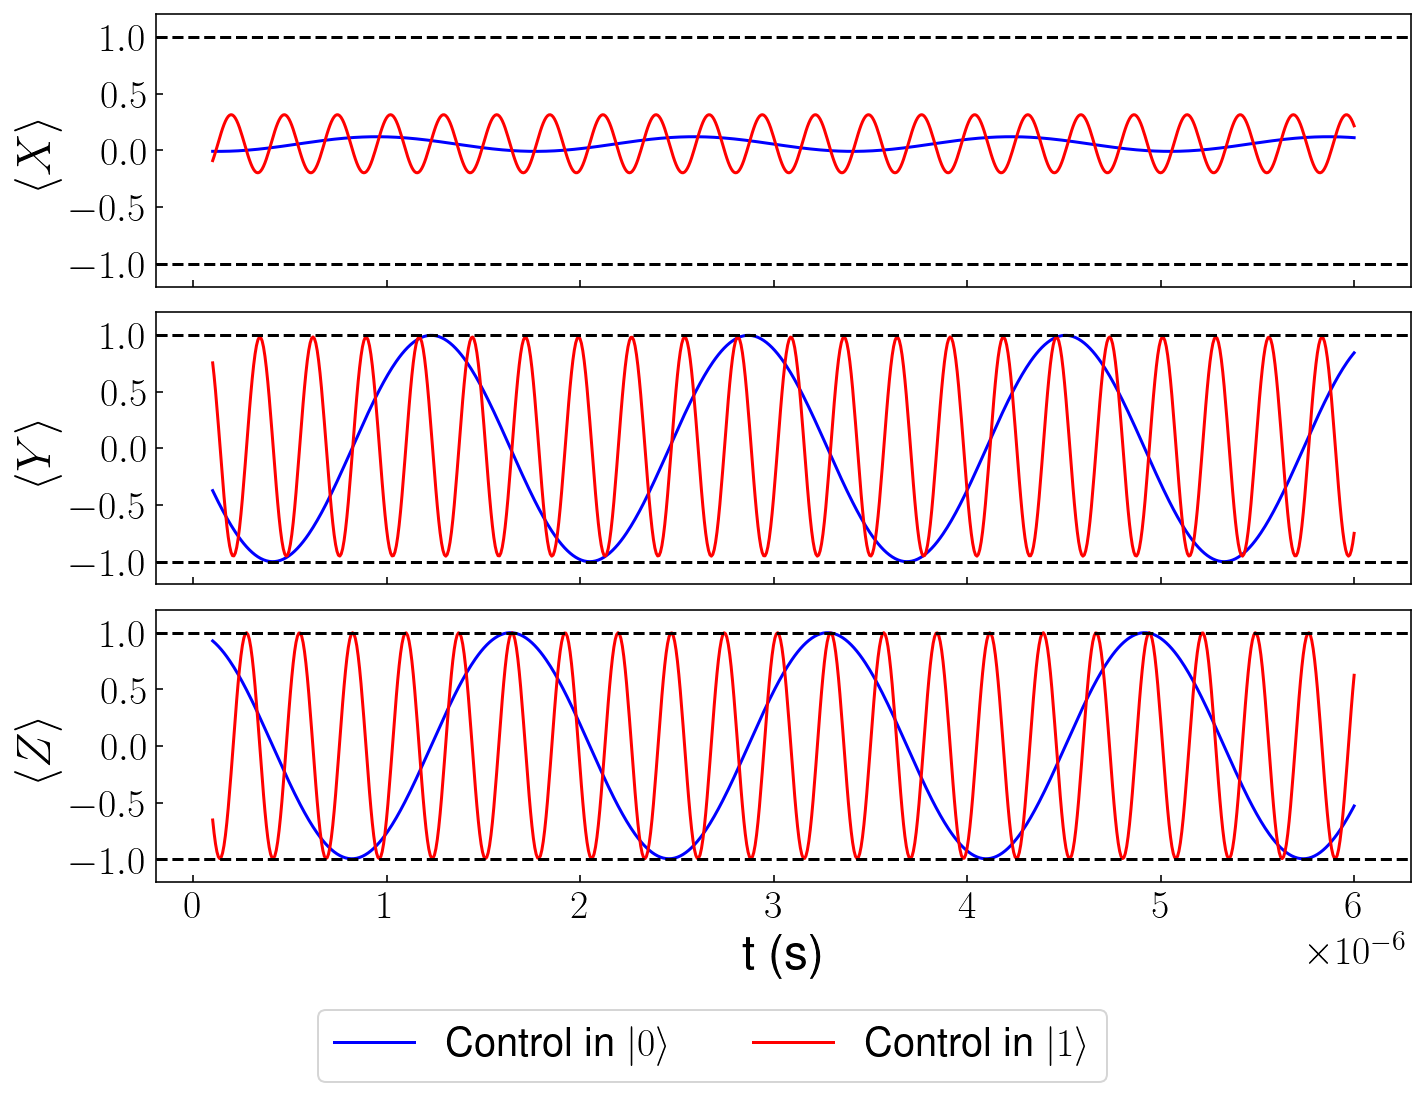

In [186]:
# Without leakage error
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=None, 
                                                    qs_model=qs_model, FLAG_noise=True)

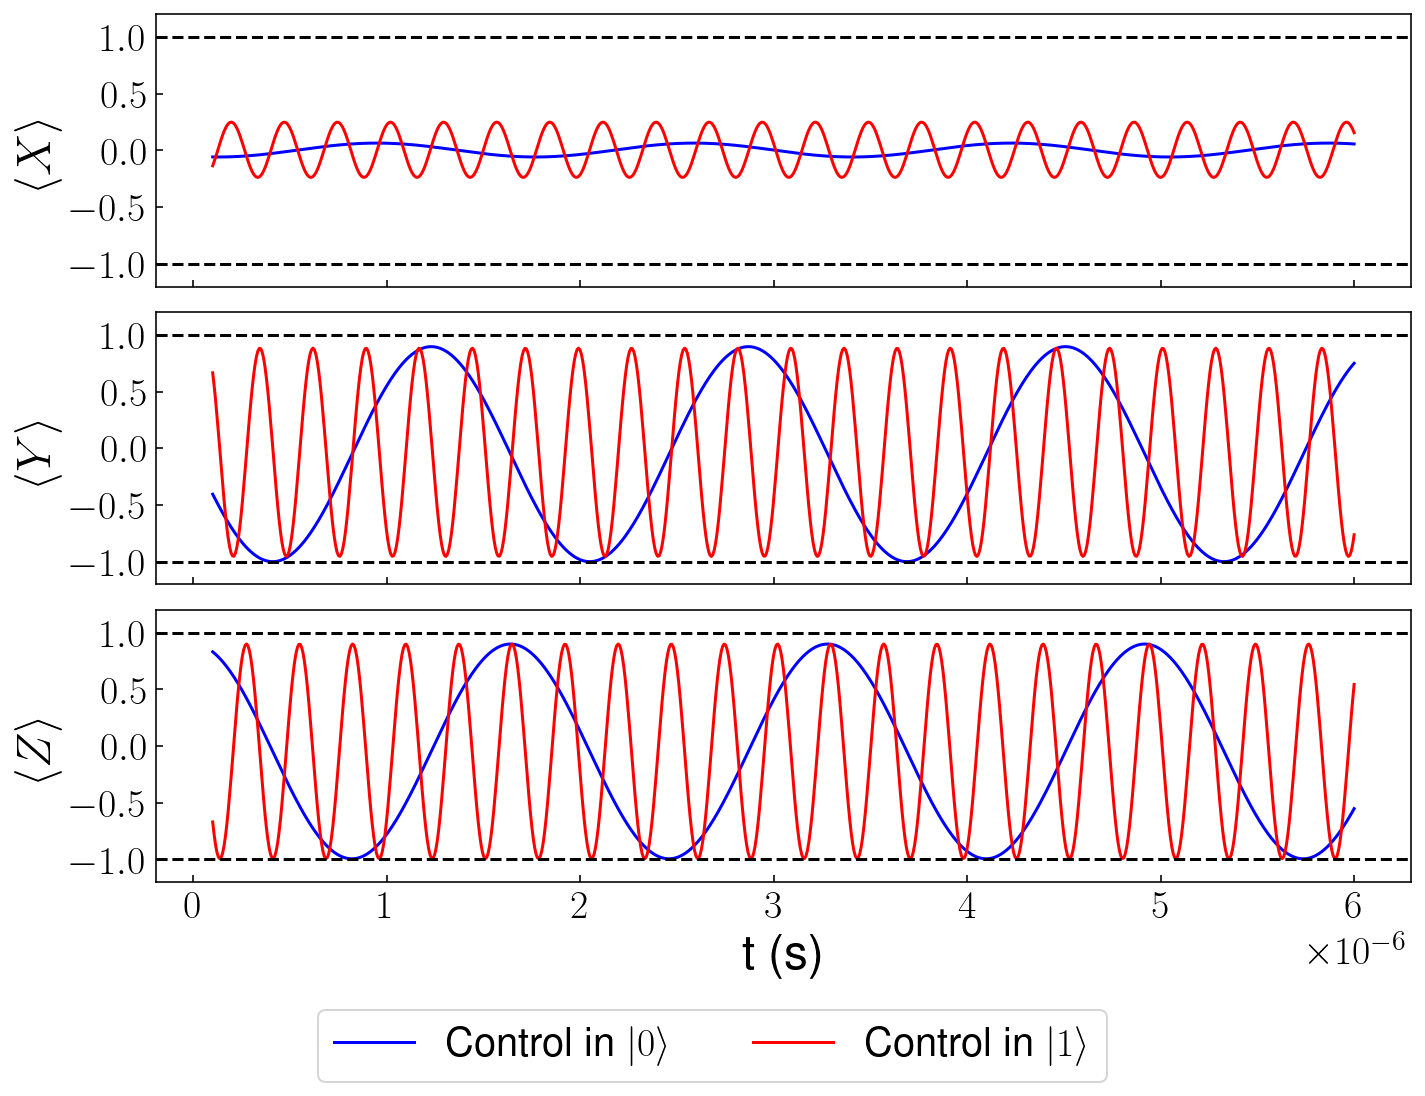

In [187]:
# With leakage error
_ = learner_experiment_utils.plot_rabi_oscillations(xi_t*time_stamps_nd, pvec_data=None, 
                                                    qs_model=qs_model_leakage, FLAG_noise=True)

In [197]:
# ActiveLearner
policy_type = 'FI'
FLAG_normalization = True
FLAG_noise = True

HAL_FI_J = design_experiment.ActiveLearner(policy_type=policy_type,
                                      FLAG_normalization=FLAG_normalization,
                                      FLAG_noise=FLAG_noise,
                                      type_param = 'J')

In [198]:
q = HAL_FI_J.optimal_query_distribution(A_cr, qs_model, p_ref=p_U, FLAG_verbose_solver=False)

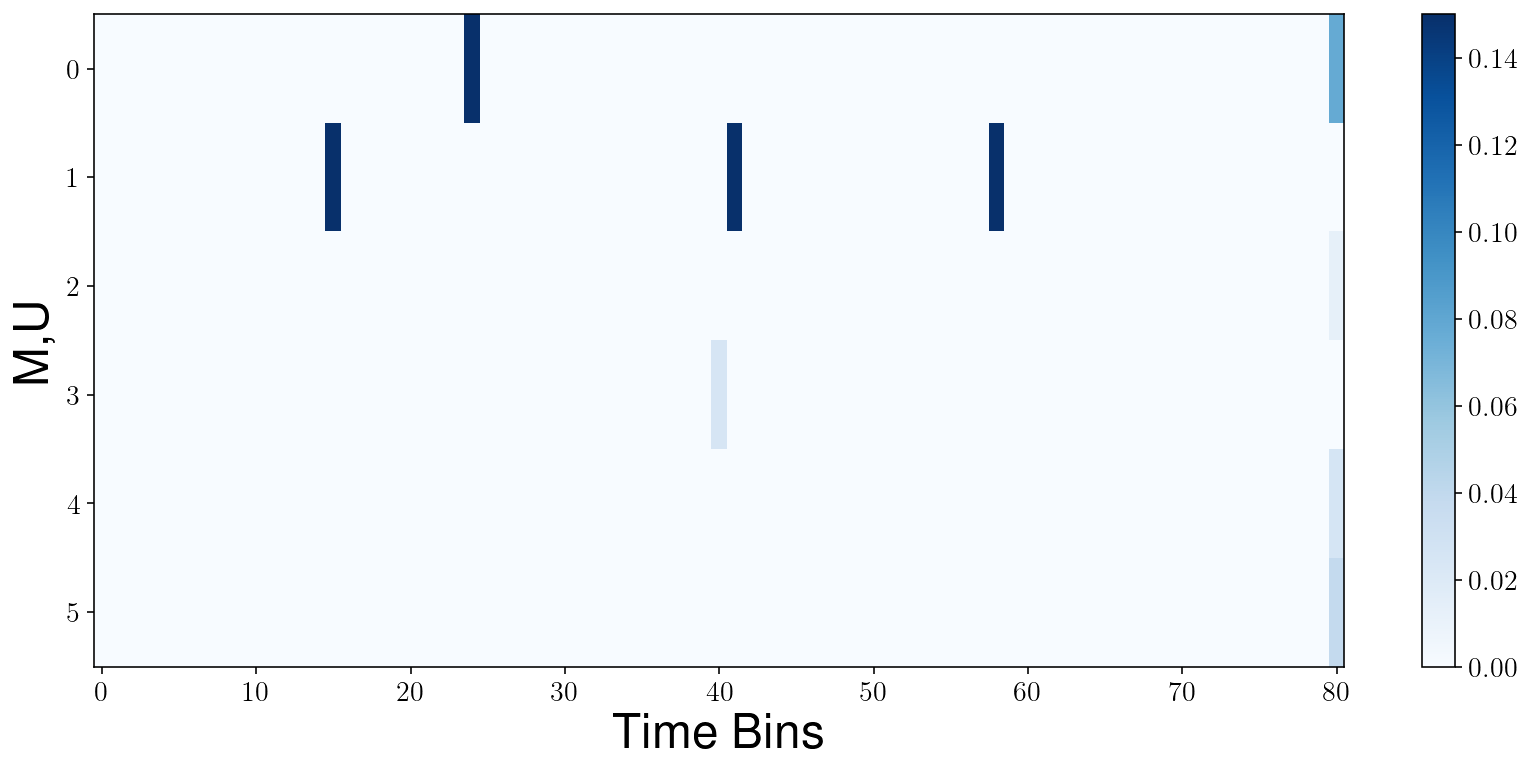

In [199]:
A_cr.visualize_query_distrn(q)

In [200]:
q = HAL_FI_J.optimal_query_distribution(A_cr, qs_model_leakage_erasure, p_ref=p_U, FLAG_verbose_solver=False)

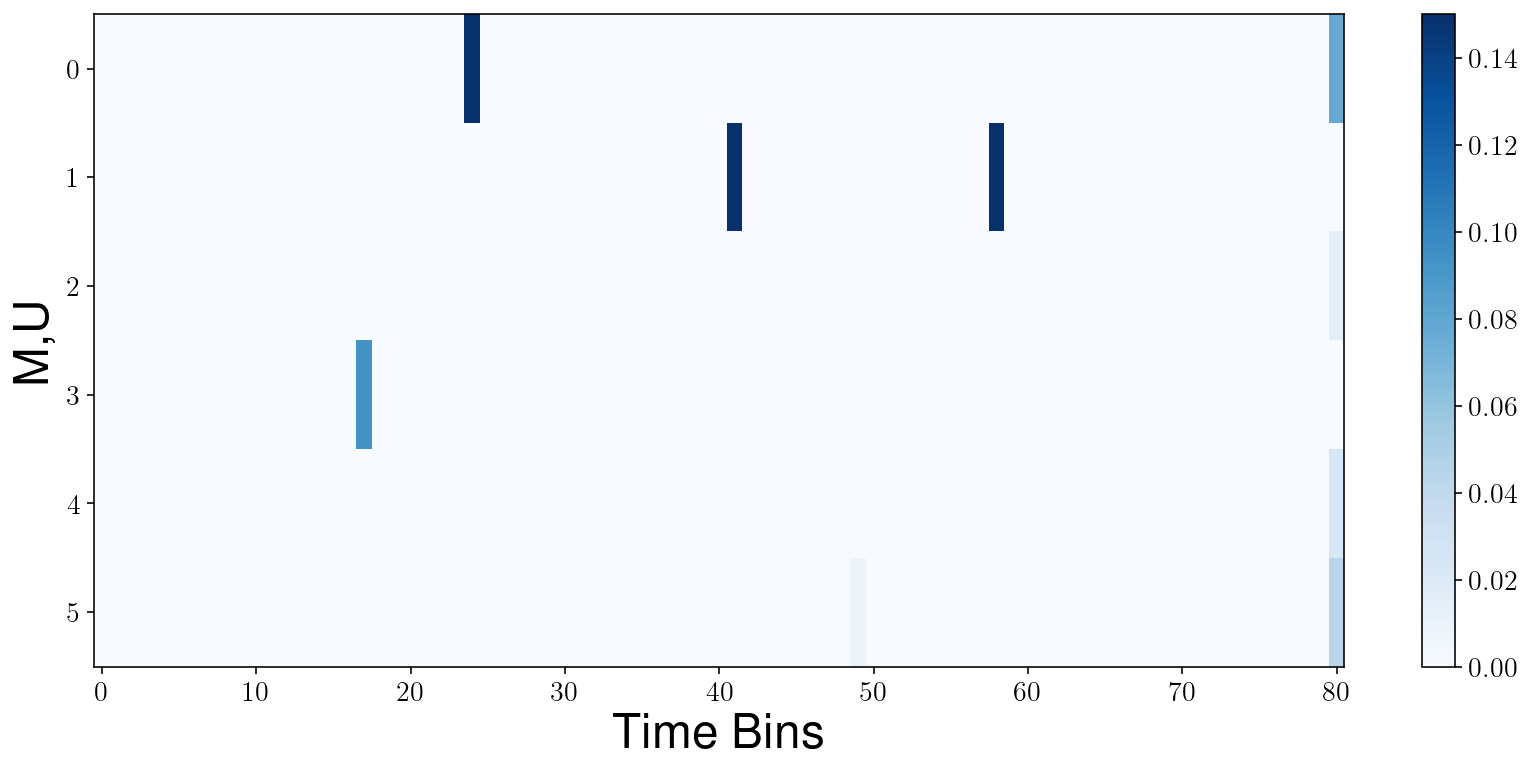

In [201]:
A_cr.visualize_query_distrn(q)

In [202]:
q = HAL_FI_J.optimal_query_distribution(A_cr, qs_model_leakage_linear, p_ref=p_U, FLAG_verbose_solver=False)

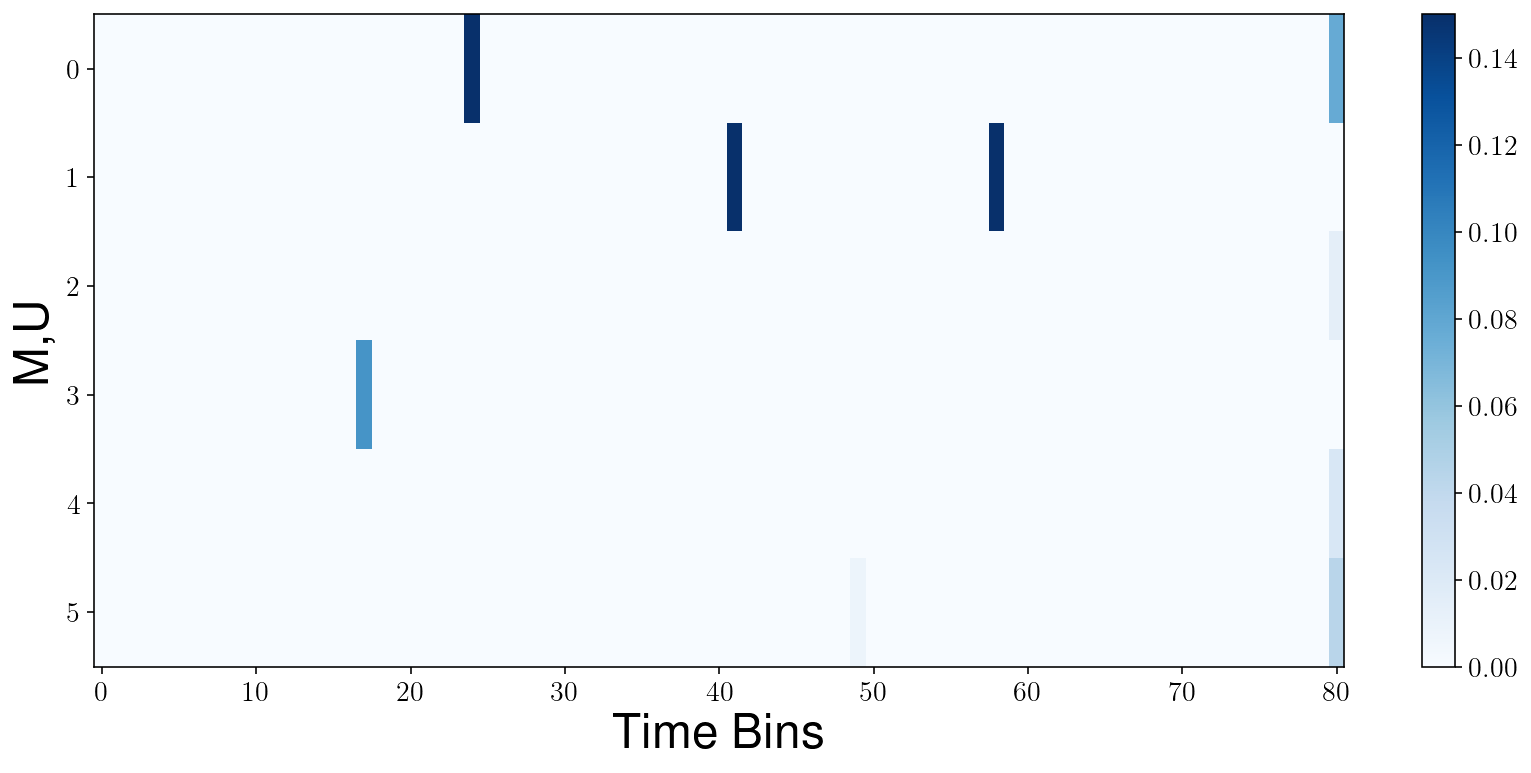

In [203]:
A_cr.visualize_query_distrn(q)

In [206]:
q = HAL_FI_J.optimal_query_distribution(A_cr, qs_model_leakage_quadratic, p_ref=p_U, FLAG_verbose_solver=False)

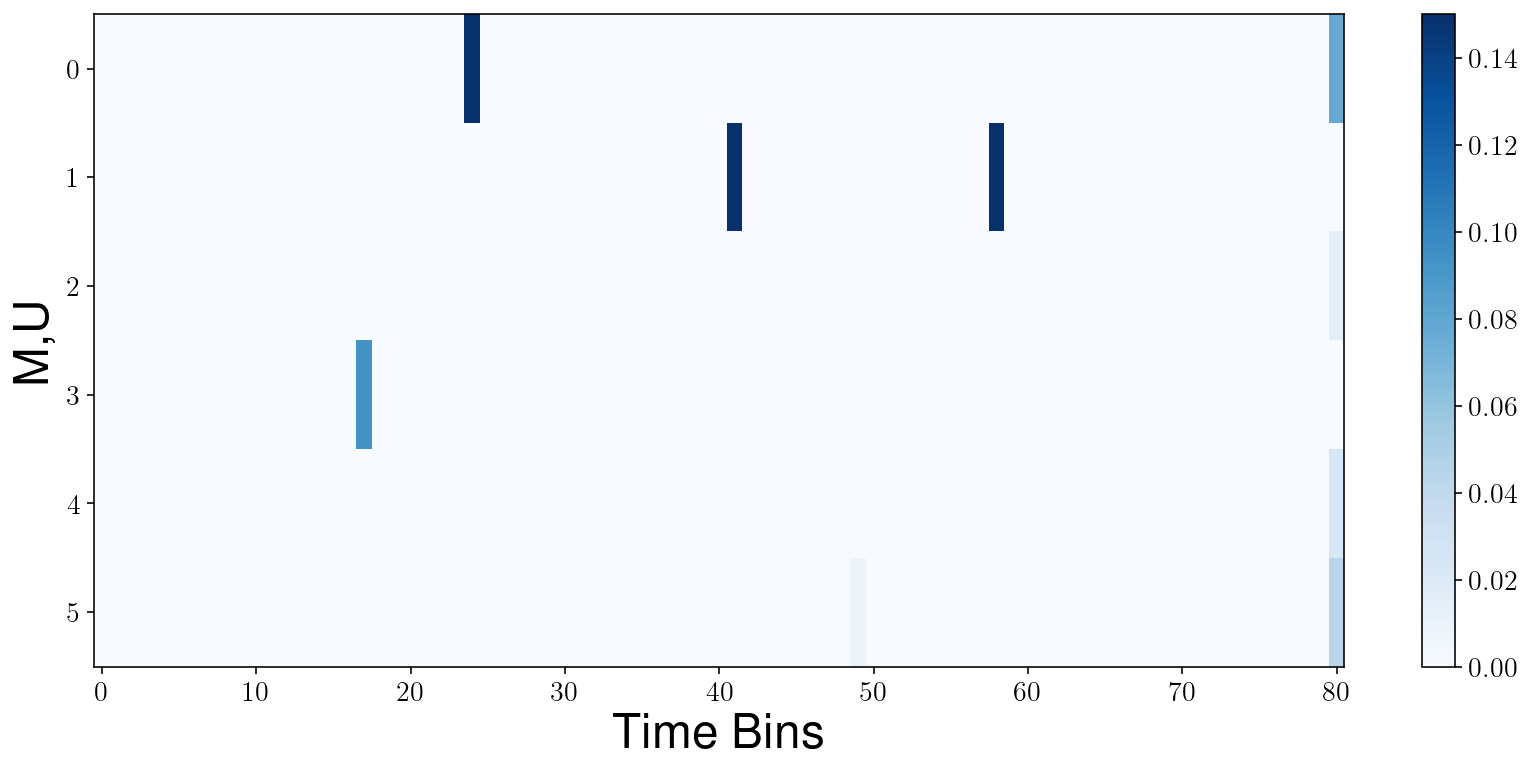

In [207]:
A_cr.visualize_query_distrn(q)